Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.5827 - loss: 0.9271 - val_accuracy: 0.7218 - val_loss: 0.6825
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - accuracy: 0.7269 - loss: 0.6722 - val_accuracy: 0.7649 - val_loss: 0.5913
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 229ms/step - accuracy: 0.7650 - loss: 0.5961 - val_accuracy: 0.7935 - val_loss: 0.5324
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.8006 - loss: 0.5113 - val_accuracy: 0.8056 - val_loss: 0.4996
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - accuracy: 0.8172 - loss: 0.4742 - val_accuracy: 0.8352 - val_loss: 0.4306
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - accuracy: 0.8404 - loss: 0.4152 - val_accuracy: 0.8457 - val_loss: 0.4074
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - accuracy: 0.8476 - loss: 0.3971 - val_accuracy: 0.8535 - val_loss: 0.3871
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.8482 - loss: 0

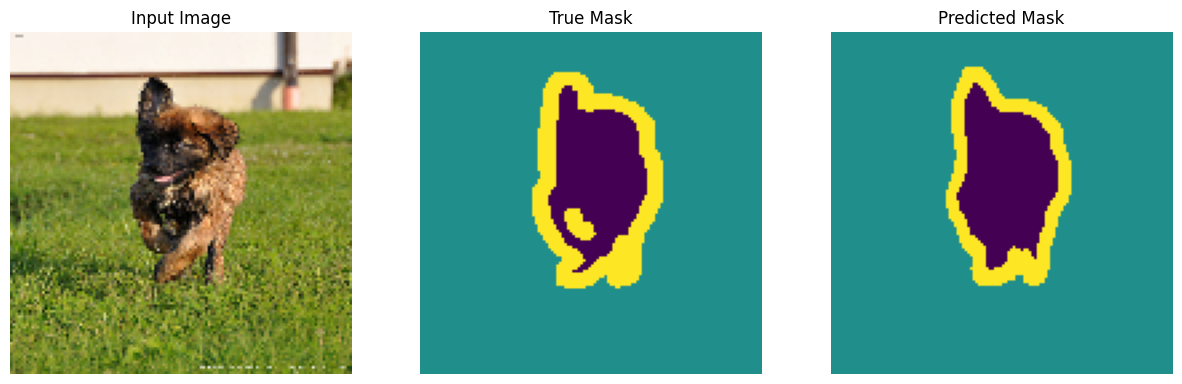

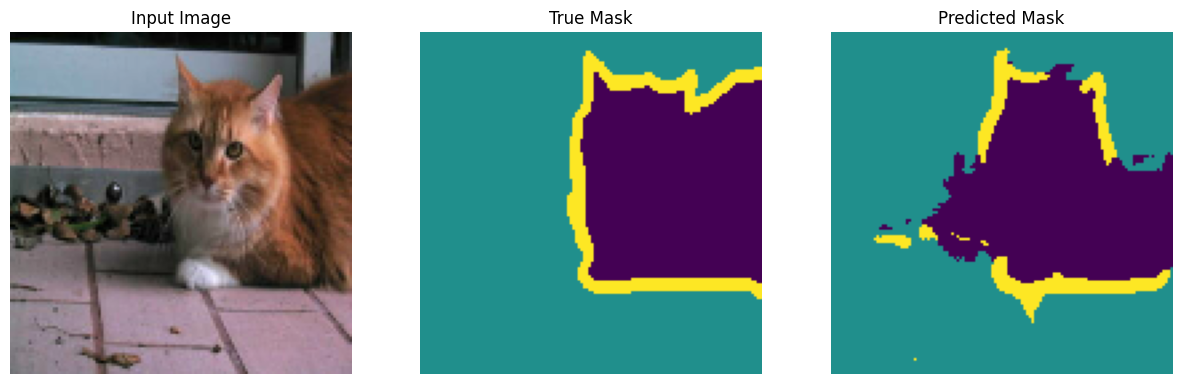

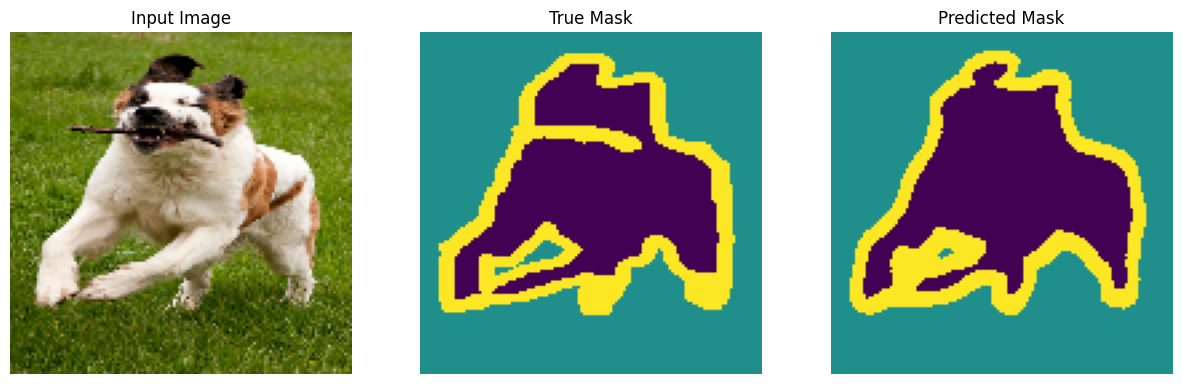

In [ ]:
!pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
IMG_SIZE = 128

def normalize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    return normalize(input_image, input_mask)

train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE)

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels

    def build(self, input_shape):
        self.query = tf.keras.layers.Conv2D(self.channels // 8, 1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, 1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, 1, padding="same")
        self.gamma = self.add_weight(
            name="gamma", shape=[1], initializer="zeros", trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]

        f = self.query(x)
        g = self.key(x)
        h_ = self.value(x)

        f_flat = tf.reshape(f, [batch_size, -1, self.channels // 8])
        g_flat = tf.reshape(g, [batch_size, -1, self.channels // 8])
        h_flat = tf.reshape(h_, [batch_size, -1, self.channels])

        beta = tf.nn.softmax(tf.matmul(f_flat, g_flat, transpose_b=True), axis=-1)
        o = tf.matmul(beta, h_flat)

        o = tf.reshape(o, [batch_size, h, w, self.channels])
        return self.gamma * o + x

def unet_with_attention(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=3):
    inputs = keras.Input(input_shape)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(bn)
    bn = SelfAttention(512)(bn)

    u3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c8)
    return keras.Model(inputs, outputs)

model = unet_with_attention()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_batches, epochs=10, validation_data=test_batches)

def display(display_list, titles=["Input Image", "True Mask", "Predicted Mask"]):
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for images, masks in test_batches.take(1):
    print(f"Images shape: {images.shape}")
    pred_mask = model.predict(images)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    for i in range(3):
        display([images[i], masks[i], pred_mask[i]])


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

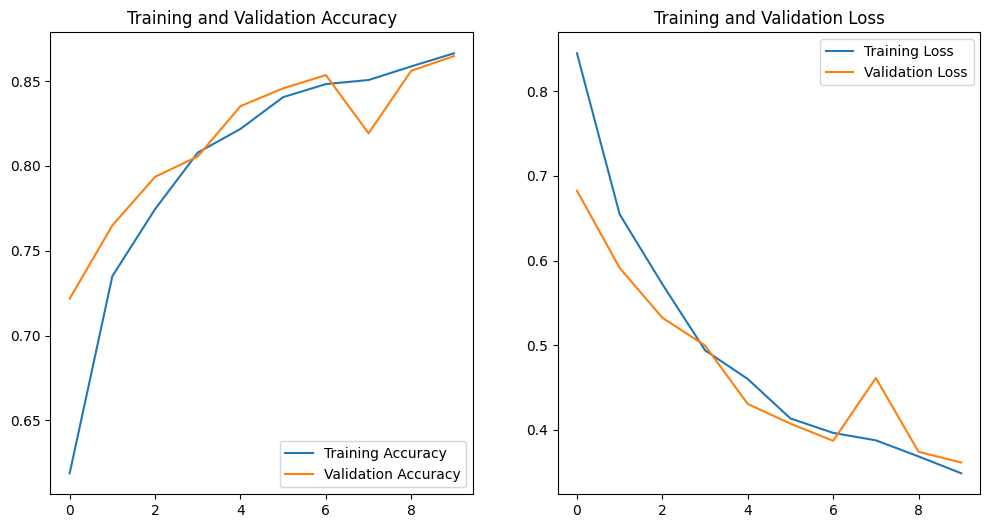

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_curve.png')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')

plt.show()


In [ ]:
def save_sample_predictions(model, test_dataset, num_samples=3):
    for images, masks in test_dataset.take(1):
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)
        preds = preds[..., tf.newaxis]

        for i in range(num_samples):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(tf.keras.utils.array_to_img(images[i]))
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            axes[1].imshow(tf.keras.utils.array_to_img(masks[i]))
            axes[1].set_title("True Mask")
            axes[1].axis('off')

            axes[2].imshow(preds[i][:, :, 0])
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            plt.savefig(f"prediction_sample_{i+1}.png")
            plt.close(fig)

save_sample_predictions(model, test_batches)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


In [ ]:
!apt-get -qq install -y graphviz
!pip install pydot

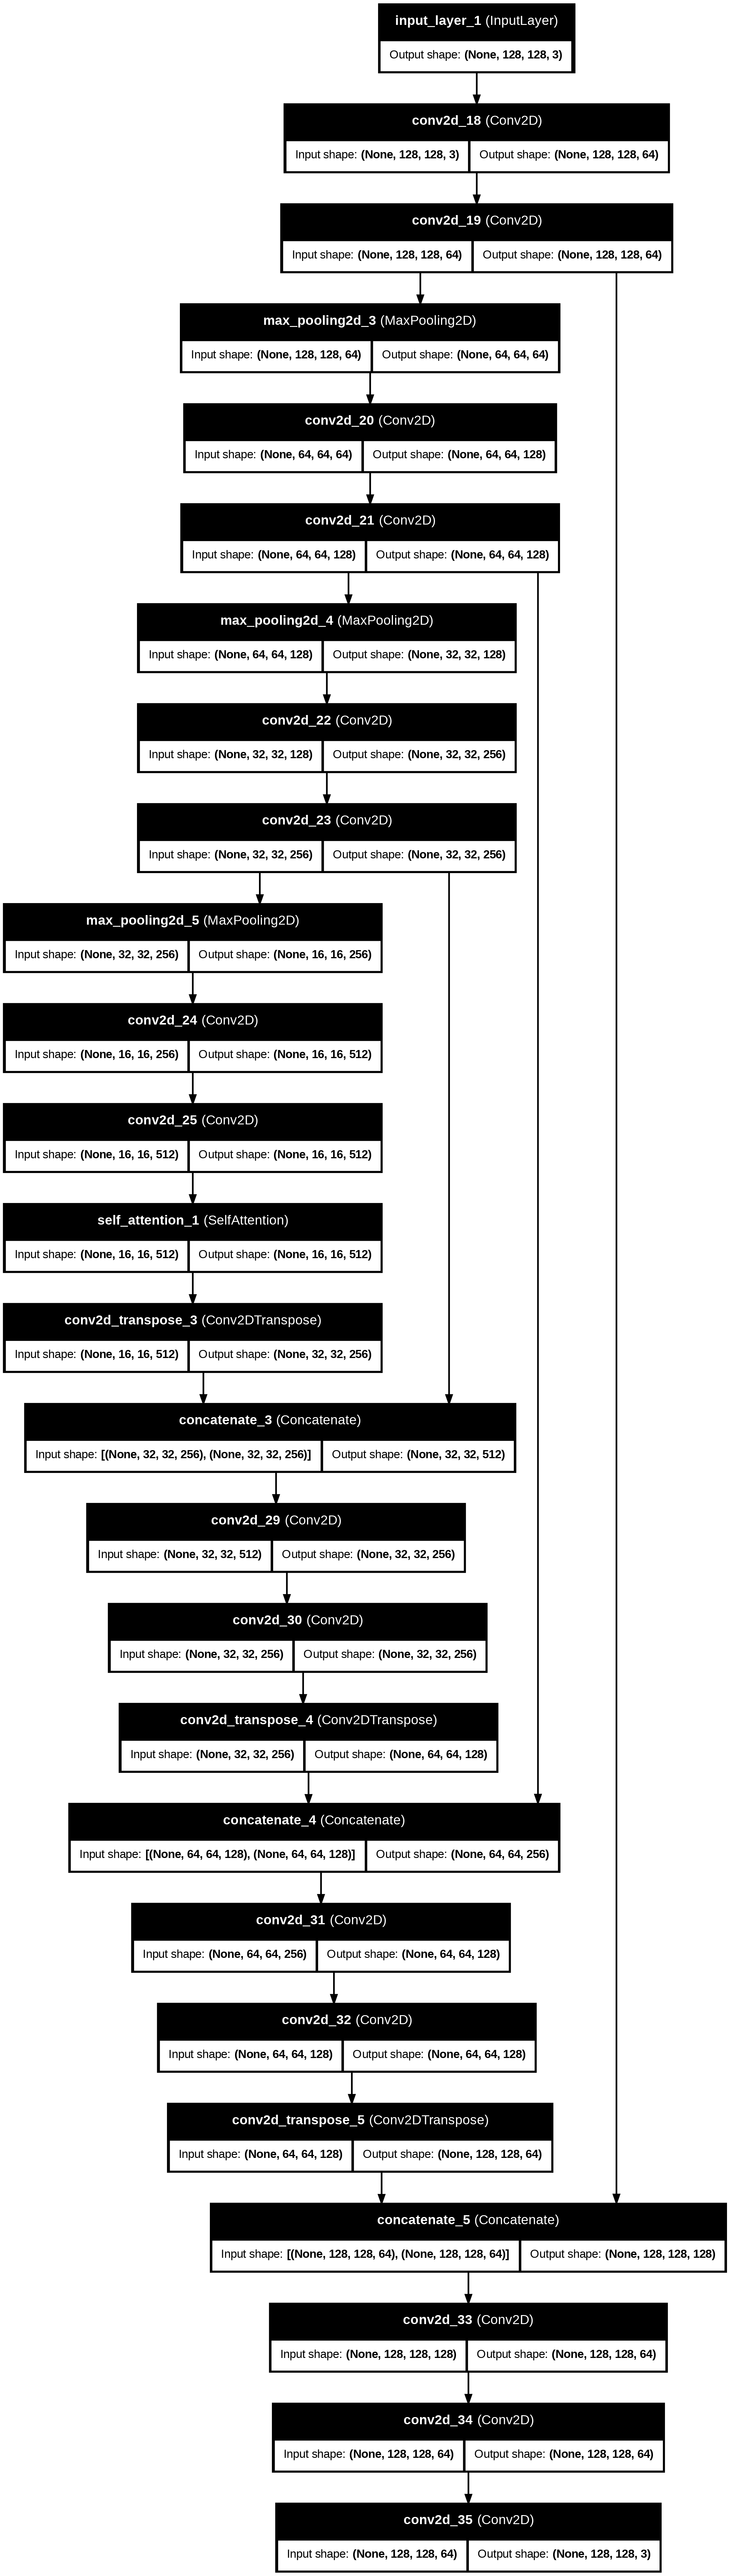

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='unet_attention_architecture.png', show_shapes=True, show_layer_names=True)
